### Домашнее задание № 3

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/MWP_example.ipynb)

In [1]:
import os
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm

In [2]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [3]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [4]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
#year = '2021'
#month = '01'
#url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
#res = requests.get(url)
#rj = res.json()
#df = pd.json_normalize(rj)
#df.head()

In [5]:
# Выгрузим данные по стоимости каучука

all_dfs = []
for y in ['2019','2020','2021','2022']:
    for m in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={m}&year={y}"
        res = requests.get(url)
        rj = res.json()
        temp_df = pd.json_normalize(rj)
        all_dfs.append(temp_df)

In [6]:
df_new=pd.concat(all_dfs)       
df_new

,date,grade,masa,rm,us,tone
0,2019-01-31,SMR CV,Noon,770.00,191.30,Quiet
1,2019-01-31,SMR L,Noon,750.00,186.35,Quiet
2,2019-01-31,SMR 5,Noon,549.50,136.50,Quiet
3,2019-01-31,SMR GP,Noon,546.50,135.80,Quiet
4,2019-01-31,SMR 10,Noon,539.50,134.05,Quiet
...,...,...,...,...,...,...
30,2022-08-01,SMR 5,Noon,680.50,155.45,Quiet
31,2022-08-01,SMR GP,Noon,677.50,154.80,Quiet
32,2022-08-01,SMR 10,Noon,670.50,153.20,Quiet
33,2022-08-01,SMR 20,Noon,668.50,152.75,Quiet


In [7]:
df_new.date.min()

'2019-01-02'

In [8]:
df_new.grade.unique()

array(['SMR CV', 'SMR L', 'SMR 5', 'SMR GP', 'SMR 10', 'SMR 20',
       'Latex in Bulk'], dtype=object)

In [9]:
# Создадим датафрейм со стоимостью каучука марки SMR_20 
df_smr_20=df_new[df_new.grade == 'SMR 20'].reset_index()
df_smr_20 = df_smr_20[['date', 'us']]
df_smr_20.columns = ['date','rubber_USD']

In [10]:
df_smr_20

,date,rubber_USD
0,2019-01-31,133.55
1,2019-01-30,133.75
2,2019-01-29,133.05
3,2019-01-28,134.40
4,2019-01-25,134.10
...,...,...
867,2022-08-05,151.70
868,2022-08-04,151.90
869,2022-08-03,153.10
870,2022-08-02,150.95


In [11]:
import datetime
from datetime import datetime, date, time


df_smr_20.date=pd.to_datetime(df_smr_20.date)
df_smr_20['month_year'] = df_smr_20['date'].dt.to_period('M')
df_smr_20['rubber_USD'] = df_smr_20['rubber_USD'].astype(float)
df_smr_20_agg=df_smr_20.groupby('month_year').agg({'rubber_USD':'mean'}).reset_index()
df_smr_20_agg

,month_year,rubber_USD
0,2019-01,135.333333
1,2019-02,139.126471
2,2019-03,147.559524
3,2019-04,151.561905
4,2019-05,152.315000
5,2019-06,152.172222
6,2019-07,142.931818
7,2019-08,131.480952
8,2019-09,133.733333
9,2019-10,130.025000


In [12]:
#Выгрузим данные по курсам валют
from tqdm.auto import tqdm

df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
df_dict

{'USDRUB=X': Date
 2003-12-31    29.402609
 2004-01-31    28.815714
 2004-02-29    28.499000
 2004-03-31    28.524644
 2004-04-30    28.684000
                 ...    
 2022-04-30    80.666187
 2022-05-31    65.422944
 2022-06-30    60.146091
 2022-07-31    61.413657
 2022-08-31    61.307884
 Freq: M, Name: Close, Length: 225, dtype: float64,
 'EURUSD=X': Date
 2003-12-31    1.231372
 2004-01-31    1.260813
 2004-02-29    1.264357
 2004-03-31    1.226723
 2004-04-30    1.199692
                 ...   
 2022-04-30    1.082745
 2022-05-31    1.057322
 2022-06-30    1.057670
 2022-07-31    1.019509
 2022-08-31    1.020182
 Freq: M, Name: Close, Length: 225, dtype: float64,
 'EURRUB=X': Date
 2003-12-31    36.187222
 2004-01-31    36.347455
 2004-02-29    36.083011
 2004-03-31          NaN
 2004-04-30    34.990002
                 ...    
 2022-04-30    86.109895
 2022-05-31    68.104363
 2022-06-30    60.378959
 2022-07-31    62.204667
 2022-08-31    62.284717
 Freq: M, Name: Close, Lengt

In [14]:
# Создадим таблицу с курсами и датой
rate = pd.concat(df_dict.values(), axis=1).reset_index()
rate.columns =['date','USDRUB', 'EURUSD', 'EURRUB']
mask = (rate['date'] >= '2019-01-31') & (rate['date'] <= '2022-08-31')
rate= rate.loc[mask].reset_index()
rate['month_year'] = rate['date'].dt.to_period('M')
rate = rate[['month_year','USDRUB','EURUSD', 'EURRUB']]
rate

,month_year,USDRUB,EURUSD,EURRUB
0,2019-01,66.883992,1.142533,76.434270
1,2019-02,65.778695,1.135397,74.735620
2,2019-03,65.115486,1.130985,73.674074
3,2019-04,64.569977,1.123492,72.561023
4,2019-05,64.876098,1.118911,72.577653
5,2019-06,64.168690,1.129002,72.458005
6,2019-07,63.176222,1.122682,70.956822
7,2019-08,65.687992,1.113163,73.143709
8,2019-09,64.971148,1.101377,71.589861
9,2019-10,64.341009,1.104839,71.093322


In [15]:
# Объединим две таблицы в одну
result = rate.merge(df_smr_20_agg, on=["month_year"])
result.head()

,month_year,USDRUB,EURUSD,EURRUB,rubber_USD
0,2019-01,66.883992,1.142533,76.434270,135.333333
1,2019-02,65.778695,1.135397,74.735620,139.126471
2,2019-03,65.115486,1.130985,73.674074,147.559524
3,2019-04,64.569977,1.123492,72.561023,151.561905
4,2019-05,64.876098,1.118911,72.577653,152.315000


In [16]:
result['MWP_PRICE_EUR'] = result.rubber_USD * (1/result.EURUSD) + 400 #затраты на производство в евро
result['MWP_PRICE_USD'] = result.rubber_USD + 400 * result.EURUSD #затраты на производство в долларах
result['MWP_PRICE_EUR_EU'] = result['MWP_PRICE_EUR'] + EU_LOGISTIC_COST_EUR # общие затраты для Европы
result['MWP_PRICE_USD_CN'] = result['MWP_PRICE_USD'] + CN_LOGISTIC_COST_USD # общие затраты для Китая
result['MWP_PRICE_EUR_EU_MA'] = result.MWP_PRICE_EUR_EU.rolling(window=3).mean() #скользящее среднее с окном 3
result.head()

,month_year,USDRUB,EURUSD,EURRUB,rubber_USD,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN,MWP_PRICE_EUR_EU_MA
0,2019-01,66.883992,1.142533,76.434270,135.333333,518.450265,592.346524,548.450265,722.346524,NaN
1,2019-02,65.778695,1.135397,74.735620,139.126471,522.535505,593.285356,552.535505,723.285356,NaN
2,2019-03,65.115486,1.130985,73.674074,147.559524,530.469967,599.953364,560.469967,729.953364,553.818579
3,2019-04,64.569977,1.123492,72.561023,151.561905,534.902513,600.958736,564.902513,730.958736,559.302662
4,2019-05,64.876098,1.118911,72.577653,152.315000,536.127883,599.879442,566.127883,729.879442,563.833454


In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

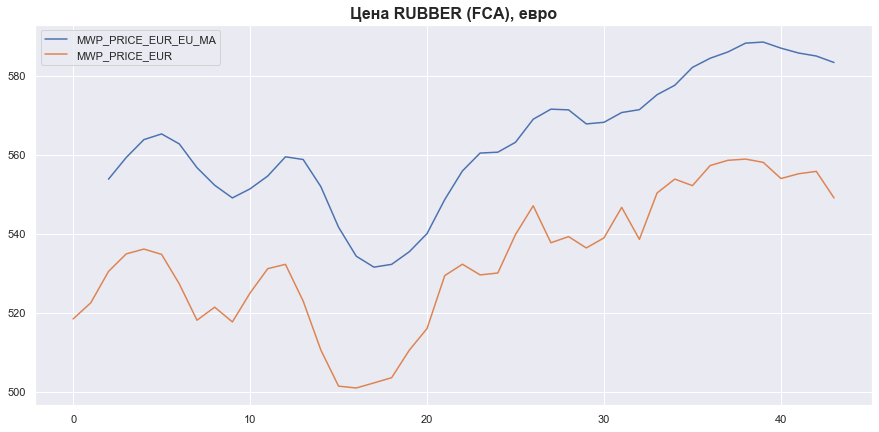

In [18]:
# График с базовой ценой(на заводе) в евро
plt.title('Цена RUBBER (FCA), евро', fontsize=16, fontweight='bold')
plt.plot(result['MWP_PRICE_EUR_EU_MA'], label='MWP_PRICE_EUR_EU_MA')
plt.plot(result['MWP_PRICE_EUR'], label='MWP_PRICE_EUR')
plt.legend()
plt.show()

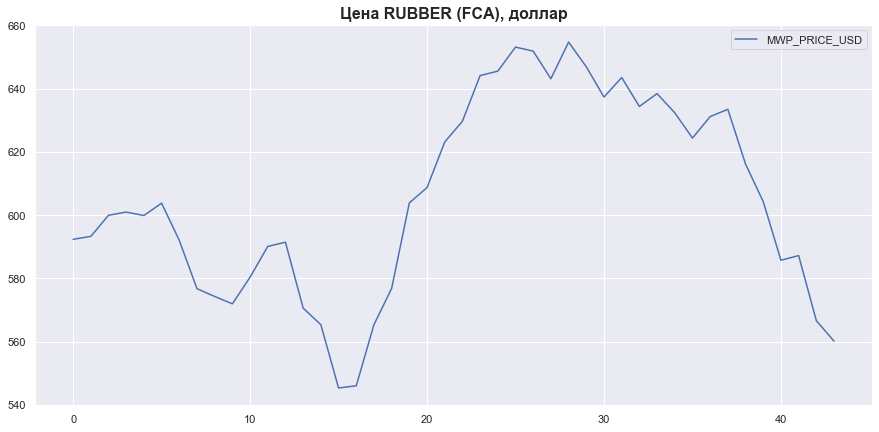

In [19]:
# График с базовой ценой(на заводе) в долларах
plt.title('Цена RUBBER (FCA), доллар', fontsize=16, fontweight='bold')
plt.plot(result['MWP_PRICE_USD'], label='MWP_PRICE_USD')
plt.legend()
plt.show()

In [20]:
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'formula': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'formula': 'monthly'}}

In [21]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

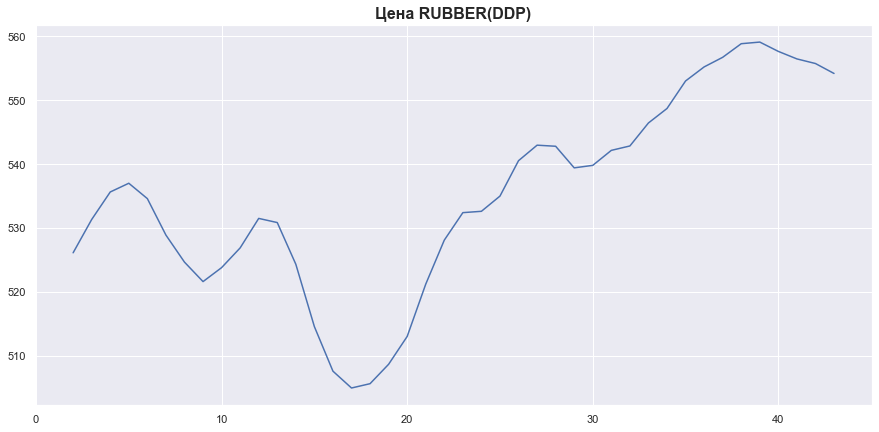

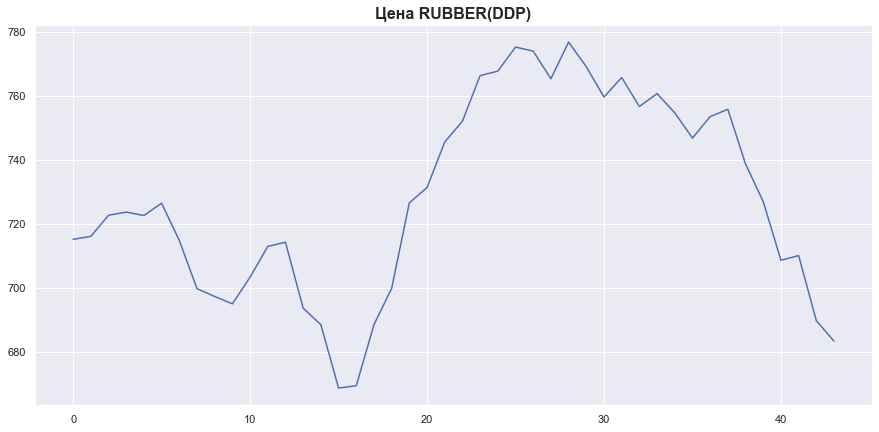

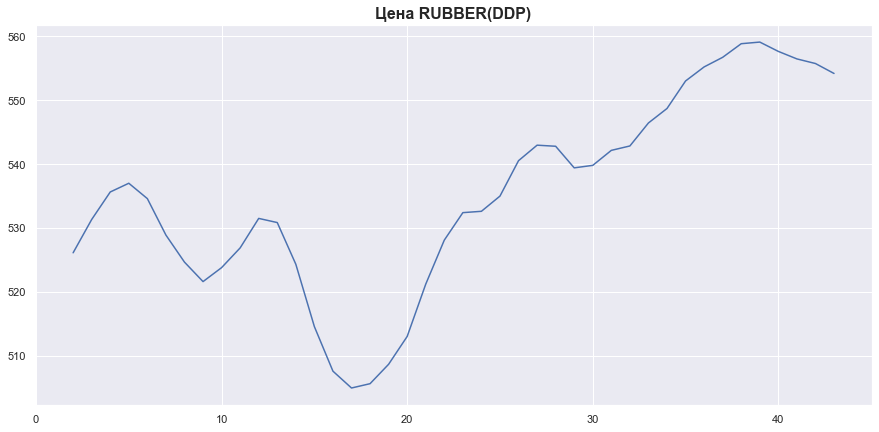

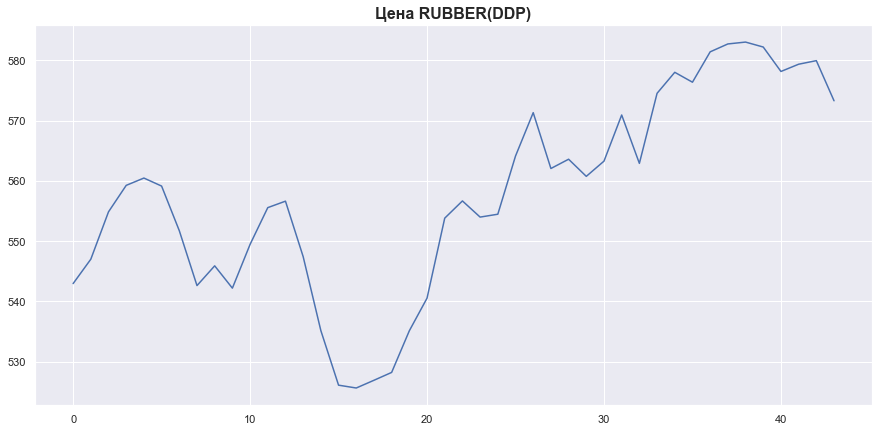

In [22]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = result['MWP_PRICE_EUR_EU'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = result['MWP_PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = result['MWP_PRICE_USD_CN'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена RUBBER(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_wbp.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [23]:
# Создаем директорию для ценовых предложений клиентам
price_proposals_path = 'client_rubber_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

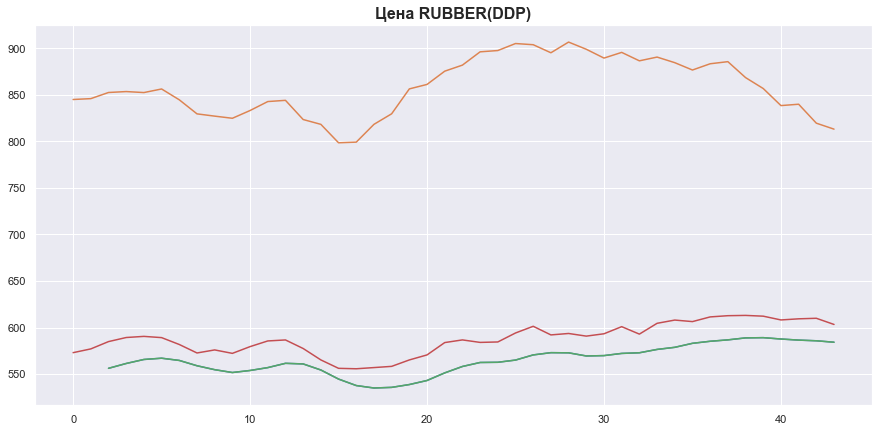

In [24]:
# Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_rubber_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = result['MWP_PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('formula') == 'moving_average':
            client_price = result['MWP_PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = result['MWP_PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена RUBBER(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [25]:
import home_modul

import importlib
importlib.reload(home_modul)

home_modul.calculate_prices()

hello
Подгружаем курсы


  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Создадим таблицу с курсами и датой
Подгружаем котировки каучука
Создаем таблицу с ценой каучука SMR 20
Объединим две таблицы в одну
Рассчитываем цены
Готовим отдельный файл для клиентов
0       NaN
1       NaN
2    556.13
3    561.34
4    565.64
Name: MWP_PRICE_EUR_EU_MA, dtype: float64
Monty готов
0    845.12
1    846.05
2    852.65
3    853.65
4    852.58
Name: MWP_PRICE_USD_CN, dtype: float64
Triangle готов
0       NaN
1       NaN
2    556.13
3    561.34
4    565.64
Name: MWP_PRICE_EUR_EU_MA, dtype: float64
Stone готов
0    572.97
1    577.01
2    584.87
3    589.25
4    590.47
Name: MWP_PRICE_EUR_EU, dtype: float64
Poly готов
Удаляем ненужные файлы
Работа завершена!


# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [26]:
!pip install first_package
import first_package

In [28]:
from first_package.modul import calculate_prices
calculate_prices()

hello
Подгружаем курсы


  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Создадим таблицу с курсами и датой
Подгружаем котировки каучука
Создаем таблицу с ценой каучука SMR 20
Объединим две таблицы в одну
Рассчитываем цены
Готовим отдельный файл для клиентов
0       NaN
1       NaN
2    556.13
3    561.34
4    565.64
Name: MWP_PRICE_EUR_EU_MA, dtype: float64
Monty готов
0    845.12
1    846.05
2    852.65
3    853.65
4    852.58
Name: MWP_PRICE_USD_CN, dtype: float64
Triangle готов
0       NaN
1       NaN
2    556.13
3    561.34
4    565.64
Name: MWP_PRICE_EUR_EU_MA, dtype: float64
Stone готов
0    572.97
1    577.01
2    584.87
3    589.25
4    590.47
Name: MWP_PRICE_EUR_EU, dtype: float64
Poly готов
Удаляем ненужные файлы
Работа завершена!
